In [88]:
# From https://neuraloperator.github.io/neuraloperator/dev/auto_examples/plot_FNO_darcy.html
from ml_model import model
from neuralop.datasets import load_darcy_flow_small
import torch
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker

In [89]:
def G_operator(x):
    """Takes a permeability field and returns the pressure field.

    Args:
        x: Permeability field.

    Returns:
        y: Pressure field.
    """    
    return model(x.unsqueeze(0))

def G_operator_Jparticles(x):
    """Takes a permeability field and returns the pressure field.

    Args:
        x: Permeability field.

    Returns:
        y: Pressure field.
    """    
    return model(x)

Loading test db at resolution 32 with 50 samples and batch-size=32


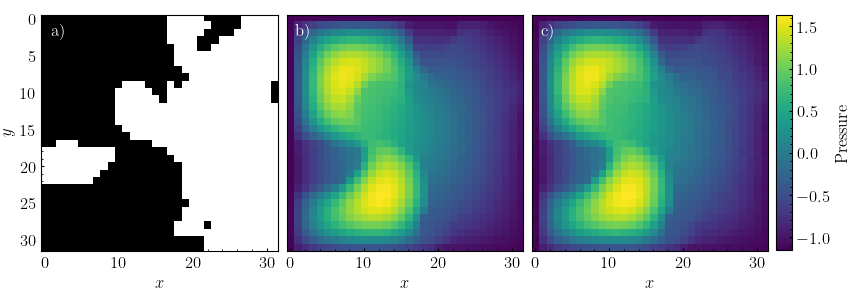

In [90]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=1000, batch_size=32,
    test_resolutions=[16, 32], n_tests=[100, 50],
    test_batch_sizes=[32, 32],
    positional_encoding=True
)
test_samples = test_loaders[32].dataset

STD_DEV = 0.01  # Standard deviation of the Gaussian noise, mean is 0
dataset = test_samples[0]
dataset = data_processor.preprocess(dataset, batched=False)
ref_permeability = dataset['x']
ref_pressure_true = dataset['y']
ref_pressure_true_noisy = ref_pressure_true + STD_DEV * torch.randn_like(ref_pressure_true)
ref_pressure_ML = G_operator(ref_permeability)

min_pressure = min(ref_pressure_true.min(), ref_pressure_true_noisy.min())
max_pressure = max(ref_pressure_true.max(), ref_pressure_true_noisy.max())

fig = plt.figure(layout="constrained", figsize=(8, 3))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, .065], height_ratios=[1], wspace=0.00, hspace=0.00)

# Plot reference permeability
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ref_permeability[0], cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference pressure
ax = fig.add_subplot(gs[0, 1])
ax.imshow(ref_pressure_true.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'b)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference noisy pressure
ax = fig.add_subplot(gs[0, 2])
ax.imshow(ref_pressure_true_noisy.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'c)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Colorbar in last column
ax_big = fig.add_subplot(gs[0, 3])
ax_big.axis('off')
norm = mpl.colors.Normalize(vmin=min_pressure, vmax=max_pressure)
ax = inset_axes(ax_big, width="100%", height="88%", loc=10)  # 10 = center
cbar = mpl.colorbar.ColorbarBase(ax, cmap='viridis', orientation='vertical', norm=norm)
cbar.set_label('Pressure')

plt.savefig('permeability_pressure.png', dpi=300, bbox_inches='tight')

EKI

In [91]:
def CGG(Gtheta):
    return np.cov(Gtheta, bias=True)
 
def CTG(theta, Gtheta):
    """Calculate the cross covariance of the previous state and the next state. 
    Note that for early steps there won't be much correlation"""
    
    num_states = theta.shape[0]
    # https://stackoverflow.com/questions/45134122/numpy-cov-returns-unexpected-output
    return np.cov(np.transpose(theta), np.transpose(Gtheta), bias=True, rowvar=False)[:num_states, num_states:]

In [92]:
def EKI_update(theta, Gtheta, y, Gamma, J=50):
    """Update the ensemble of states using the EKI update formula"""
    update = CTG(theta, Gtheta) @ np.linalg.inv(Gamma + CGG(Gtheta)) @ (np.repeat(y, J).reshape(y.shape[0], J)+np.random.normal(0, STD_DEV,size=(y.shape[0],J)) - Gtheta)
    return theta + update, np.linalg.norm(update)
#EKI_update(theta0, theta, y, np.eye(40) * 0.01)

In [93]:
#Set up inverse problem
y = ref_pressure_true_noisy[0].reshape(-1).numpy()
x = ref_permeability[0].reshape(-1).numpy()

J=200
theta0 = np.random.normal(0,1,size=(x.shape[0],J))#+x.repeat(J).reshape(x.shape[0],J)
# theta0 = np.random.choice([0, 1], size=(x.shape[0],J), p=[1./2, 1/2.])


In [109]:
# now we can run the EKI algorithm
iters = 10*10*10
next_theta = theta0
for i in range(iters):
    tmp = torch.tensor(next_theta).permute((1,0)).unsqueeze(1)
    next_ml_input = torch.tensor(next_theta).permute((1,0)).unsqueeze(1).reshape(J,1,ref_pressure_true_noisy.shape[-2],ref_pressure_true_noisy.shape[-1])
    #append positional encoding
    #next_ml_input = next_ml_input + torch.randn_like(next_ml_input) * 0.01
    next_ml_input = torch.cat([next_ml_input, ref_permeability.unsqueeze(0).repeat(J,1,1,1)[:,1:2,...],ref_permeability.unsqueeze(0).repeat(J,1,1,1)[:,2:,...]], dim=1)
    G_theta = G_operator_Jparticles(next_ml_input.float())
    G_theta = G_theta.reshape(J, -1).permute((1,0)).detach().numpy()
    next_theta, norm = EKI_update(next_theta, G_theta, y, np.eye(y.shape[0]) * STD_DEV, J=J)
    if i % 20 == 0:
        print(i, norm)
    if norm < 1e-4:
        print(i, norm)
        break
EKI_pred = next_theta.mean(axis=1).reshape(ref_permeability.shape[-2],ref_permeability.shape[-1])

0 608.4392988049027
20 2.587487064621644
40 1.4658248111396146
60 1.0464593030440703
80 0.7580568454933847
100 0.5662141689633092
120 0.445746244440959
140 0.3692850288632379
160 0.3122357199678628
180 0.2734081917925579
200 0.24184383705374687
220 0.2180940814960553
240 0.19863342381974475
260 0.18235061677614073
280 0.1698515768671434
300 0.1587950391462985
320 0.14928924176932887
340 0.1410045349866776
360 0.13383881158126057
380 0.12704781765284018
400 0.12083685466789099
420 0.11480565507037252
440 0.1093866533989946
460 0.10462016149417191
480 0.10002596100997019
500 0.09618942359715207
520 0.09227693789682666
540 0.08888589257650342
560 0.08562730340230887
580 0.08248378833197763
600 0.0793095089060964
620 0.07653185342208572
640 0.074106673397752
660 0.07156198967835889
680 0.06940659541982296
700 0.06705106689139219
720 0.06486694416256607
740 0.06287633627703883
760 0.06062531189074462
780 0.0589432969050123
800 0.057051207697275286
820 0.055434074774374835
840 0.053651338670

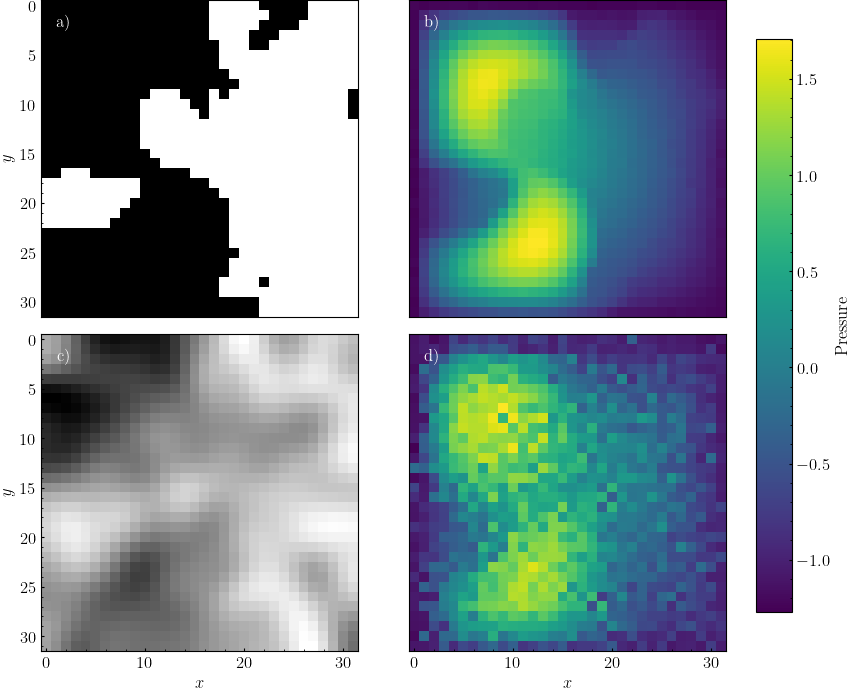

In [120]:
# Get pressure of the EKI prediction
ref_1 = torch.tensor(EKI_pred).unsqueeze(0).float()
ref_2 = ref_permeability[1:2,...]
ref_3 = ref_permeability[2:,...]
EKI_pred_input = torch.cat([ref_1, ref_2, ref_3])
EKI_pred_pressure = G_operator(EKI_pred_input).squeeze().detach().numpy()

min_pressure = min(ref_pressure_true.min(), EKI_pred_pressure.min())
max_pressure = max(ref_pressure_true.max(), EKI_pred_pressure.max())

fig = plt.figure(layout="constrained", figsize=(8, 7))
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, .1], height_ratios=[1, 1], wspace=0.00, hspace=0.00)

# Plot reference permeability
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ref_permeability[0], cmap='gray')
plt.ylabel(r'$y$')
plt.xticks([], [])
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference noisy pressure
ax = fig.add_subplot(gs[0, 1])
ax.imshow(ref_pressure_true_noisy.squeeze().detach().numpy())
plt.yticks([], [])
plt.xticks([], [])
plt.text(0.07, 0.93, 'b)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot EKI permeability
from scipy.ndimage import gaussian_filter
result = gaussian_filter(EKI_pred, sigma=2)

ax = fig.add_subplot(gs[1, 0])
ax.imshow(result, cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'c)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot EKI pressure
ax = fig.add_subplot(gs[1, 1])
ax.imshow(EKI_pred_pressure, vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'd)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Colorbar in last column
ax_big = fig.add_subplot(gs[:, 2])
ax_big.axis('off')
norm = mpl.colors.Normalize(vmin=min_pressure, vmax=max_pressure)
ax = inset_axes(ax_big, width="100%", height="88%", loc=10)  # 10 = center
cbar = mpl.colorbar.ColorbarBase(ax, cmap='viridis', orientation='vertical', norm=norm)
cbar.set_label('Pressure')

plt.savefig('permeability_pressure.png', dpi=300, bbox_inches='tight')

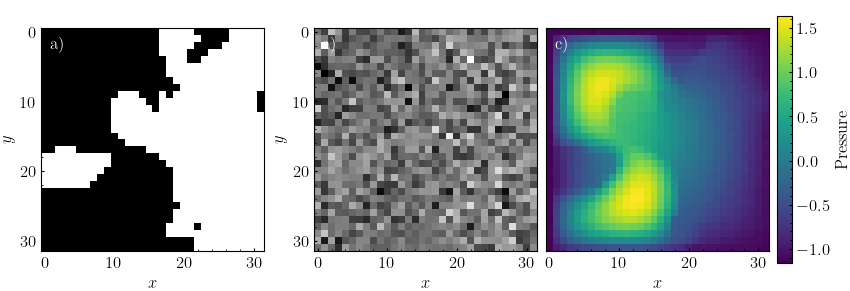

In [98]:

min_pressure = min(ref_pressure_true.min(), ref_pressure_true_noisy.min())
max_pressure = max(ref_pressure_true.max(), ref_pressure_true_noisy.max())

fig = plt.figure(layout="constrained", figsize=(8, 3))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, .065], height_ratios=[1], wspace=0.00, hspace=0.00)

# Plot reference permeability
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ref_permeability[0], cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot pred permeability
ax = fig.add_subplot(gs[0, 1])
ax.imshow(EKI_pred, cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference noisy pressure
ax = fig.add_subplot(gs[0, 2])
ax.imshow(ref_pressure_true_noisy.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'c)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Colorbar in last column
ax_big = fig.add_subplot(gs[0, 3])
ax_big.axis('off')
norm = mpl.colors.Normalize(vmin=min_pressure, vmax=max_pressure)
ax = inset_axes(ax_big, width="100%", height="88%", loc=10)  # 10 = center
cbar = mpl.colorbar.ColorbarBase(ax, cmap='viridis', orientation='vertical', norm=norm)
cbar.set_label('Pressure')

plt.savefig('permeability_pressure.png', dpi=300, bbox_inches='tight')

MCMC

In [96]:
def propnu(u, y=y, noise=0.1):
    u = torch.tensor(u).reshape(1,ref_permeability.shape[-2],ref_permeability.shape[-1])
    u = torch.cat([u, ref_permeability[1:2,...],ref_permeability[2:,...]], dim=0).float()
    return np.exp(-0.5 * np.transpose(y - G_operator(u).reshape(-1).detach().numpy()) @ (np.eye(y.shape[0]) * noise) @ np.linalg.inv(np.eye(y.shape[0]) * noise) @ (y - G_operator(u).reshape(-1).detach().numpy()))

def q(u):
    return np.random.multivariate_normal(u, np.eye(y.shape[0]))

def propq(u,v):
    return np.exp(-0.5 * np.transpose(u - v) @ np.linalg.inv(np.eye(y.shape[0])) @ (u - v))

def proprho(u):
    return np.exp(-0.5 * np.transpose(u) @ np.linalg.inv(np.eye(y.shape[0])) @ u)

def a(u, v):
    return min(1, propnu(v, y) * propq(v,u) * proprho(v) / \
               (propnu(u, y) * propq(u,v) * proprho(u)))


In [97]:
# update q(u) to use the covariance matrix of the EKI result
scale = 0.01
def q(u):
    return np.random.multivariate_normal(u, np.eye(y.shape[0]) * scale)


# with our functions defined we can now run the MCMC algorithm
n_samples = 100
samples = np.zeros((n_samples, y.shape[0]))

# update initial guess to use the mean of the eki result 
samples[0] = EKI_pred.reshape(-1)

# run Metropolis Hastings
probs, accepted = np.zeros(n_samples), np.zeros(n_samples)
for i in range(1, n_samples):
    u = samples[i-1]
    v = q(u)
    accept_prob = a(u, v)
    probs[i] = accept_prob
    if np.random.rand() < accept_prob:
        accepted[i] = 1
        samples[i] = v
    else:
        samples[i] = u
print(f"Acceptance rate: {accepted.mean()}")

MCMC_pred0 = samples.mean(axis=0).reshape(ref_permeability.shape[-2],ref_permeability.shape[-1])

KeyboardInterrupt: 

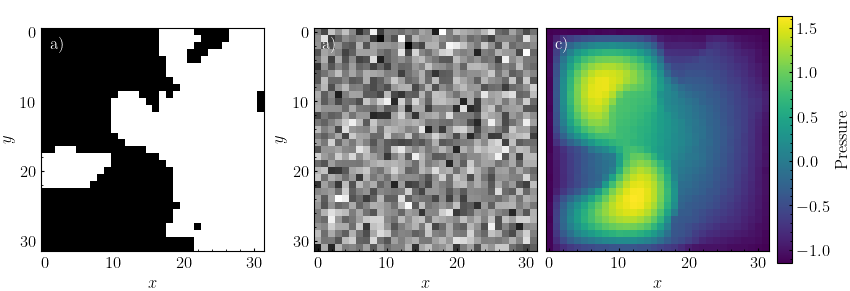

In [ ]:
min_pressure = min(ref_pressure_true.min(), ref_pressure_true_noisy.min())
max_pressure = max(ref_pressure_true.max(), ref_pressure_true_noisy.max())

fig = plt.figure(layout="constrained", figsize=(8, 3))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, .065], height_ratios=[1], wspace=0.00, hspace=0.00)

# Plot reference permeability
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ref_permeability[0], cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot pred permeability
ax = fig.add_subplot(gs[0, 1])
ax.imshow(MCMC_pred0, cmap='gray')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.text(0.07, 0.93, 'a)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Plot reference noisy pressure
ax = fig.add_subplot(gs[0, 2])
ax.imshow(ref_pressure_true_noisy.squeeze().detach().numpy(), vmin=min_pressure, vmax=max_pressure)
plt.xlabel(r'$x$')
plt.yticks([], [])
plt.text(0.07, 0.93, 'c)', transform=ax.transAxes, ha='center', va='center', zorder=100, color='white')

# Colorbar in last column
ax_big = fig.add_subplot(gs[0, 3])
ax_big.axis('off')
norm = mpl.colors.Normalize(vmin=min_pressure, vmax=max_pressure)
ax = inset_axes(ax_big, width="100%", height="88%", loc=10)  # 10 = center
cbar = mpl.colorbar.ColorbarBase(ax, cmap='viridis', orientation='vertical', norm=norm)
cbar.set_label('Pressure')

plt.savefig('permeability_pressure.png', dpi=300, bbox_inches='tight')